In [1]:
import pandas as pd 

from sklearn.model_selection import TimeSeriesSplit
from sklearn.feature_selection import SequentialFeatureSelector
from sklearn.preprocessing import MinMaxScaler
from sklearn.metrics import accuracy_score


from sklearn.linear_model import LogisticRegression
from sklearn.svm import SVC
from sklearn.neural_network import MLPClassifier
from sklearn.tree import DecisionTreeClassifier

In [2]:
data_df = pd.read_csv("final_data/averages.csv", index_col=0)

data_df = data_df.dropna()

betting = pd.read_csv("final_data/betting.csv")

In [3]:
removed_columns = ["season", "date", "won", "target", "team", "team_opp"]
selected_columns = data_df.columns[~data_df.columns.isin(removed_columns)]


scaler = MinMaxScaler()
data_df[selected_columns] = scaler.fit_transform(data_df[selected_columns])

In [4]:
data_df_train_val = data_df[data_df.season != 2022]

target_train_val = data_df.target

data_df_test = data_df[data_df.season == 2022]

target_test = data_df_test.target

betting_test = betting[betting.season == 2022]

In [5]:
# model = LogisticRegression()
# model = SVC(probability=True)
model = MLPClassifier()
# model = DecisionTreeClassifier()

In [6]:
split = TimeSeriesSplit(n_splits=6)

sfs = SequentialFeatureSelector(model, 
                                n_features_to_select=30, 
                                direction="forward",
                                cv=split,
                                n_jobs=1,
                                scoring='accuracy'
                               )

In [7]:
sfs.fit(data_df_train_val[selected_columns], data_df_train_val["target"])

/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

SequentialFeatureSelector(cv=TimeSeriesSplit(gap=0, max_train_size=None, n_splits=6, test_size=None),
                          estimator=MLPClassifier(), n_features_to_select=30,
                          n_jobs=1, scoring='accuracy')

In [8]:
predictors = list(selected_columns[sfs.get_support()])

In [17]:
from sklearn.model_selection import GridSearchCV

param_grid = {
    'hidden_layer_sizes': [(50,), (100,), (50, 50), (100, 100)],
    'activation': ['relu', 'tanh', 'logistic'],
    'solver': ['adam', 'sgd'],
    'alpha': [0.0001, 0.001, 0.01],
    'learning_rate': ['constant', 'adaptive'],
}

grid_search = GridSearchCV(estimator=model, param_grid=param_grid)

grid_search.fit(data_df_train_val[predictors], data_df_train_val["target"])

model_fitted = grid_search.best_estimator_

print(grid_search.best_params_)

all_results = grid_search.cv_results_

for i in range(len(all_results['params'])):
    print(f"Parameters: {all_results['params'][i]}")
    print(f"Mean Test Score: {all_results['mean_test_score'][i]:.2f}")

/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converged yet.
  warnings.warn(
/home/cometku/miniconda3/envs/mlfinal/lib/python3.10/site-packages/sklearn/neural_network/_multilayer_perceptron.py:691: ConvergenceWarning: Stochastic Optimizer: Maximum iterations (200) reached and the optimization hasn't converge

In [9]:
# model_fitted = model.fit(data_df_train_val[predictors], data_df_train_val["target"])

In [10]:
def moneyline_to_decimal(moneyline):
    if moneyline > 0:
        return (moneyline / 100) + 1
    else:
        return (100 / abs(moneyline)) + 1

In [11]:
def calculate_return(moneyline_odds, bet_amount):
    if moneyline_odds > 0:
        return bet_amount * (moneyline_odds / 100) + bet_amount
    else:
        return bet_amount * (100 / abs(moneyline_odds)) + bet_amount

In [12]:
def backtest(data, betting, target, model, predictors):

    principal = 1000 

    principal_over_time = [principal]

    for (i,data_row),(j,betting_row), (k, target) in zip(data[predictors].iterrows(), betting.iterrows(), target.items()):

        home_decimal_odds = moneyline_to_decimal(betting_row["HomeML"])

        away_decimal_odds = moneyline_to_decimal(betting_row["AwayML"])

        prediction_row = pd.DataFrame(data_row).T
    
        home_or_away = model.predict(prediction_row)

        away_prob,home_prob = model.predict_proba(prediction_row)[0]

        if home_or_away == 1:
            bet = principal*(home_prob - away_prob/home_decimal_odds)

            odds = home_decimal_odds

            predicted_prob = home_prob
        else:
            bet = principal*(away_prob - home_prob/away_decimal_odds)

            odds = away_decimal_odds

            predicted_prob = away_prob
        
        principal -= bet

        if home_or_away == target:
            principal += calculate_return(odds, bet)
        
        principal_over_time.append(principal)
    
    return principal_over_time

In [13]:
principal_over_time = backtest(data_df_test, betting_test, target_test, model_fitted, predictors)

In [14]:
import seaborn as sns

<Axes: >

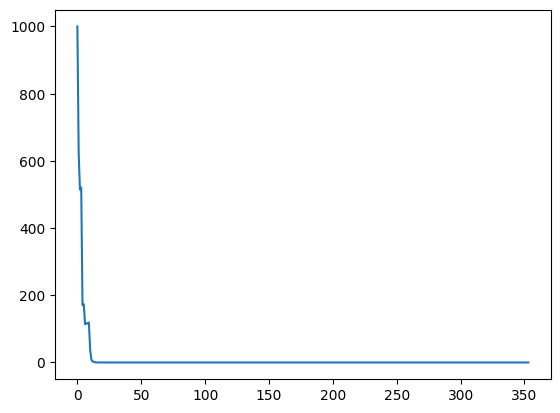

In [15]:
sns.lineplot(x=range(len(principal_over_time)), y=principal_over_time)